<a href="https://colab.research.google.com/github/fpichi/gca-rom/blob/main/notebook/01_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
# Clone and import gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/fpichi/gca-rom.git
    sys.path.append('gca-rom')
else:
    sys.path.append('../..')

from gca_rom import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui

In [4]:
import numpy as np
from itertools import product

# Define PDE problem
For the description of the model and generation of the dataset look at: [RBniCS/tutorials/09_advection_dominated](https://github.com/RBniCS/RBniCS/blob/master/tutorials/09_advection_dominated/tutorial_advection_dominated_1_pod.ipynb)

In [5]:
problem_name, variable, mu_space, n_param, dim_pde, n_comp = pde.problem(2)
argv = gui.hyperparameters_selection(problem_name, variable, n_param, n_comp)
HyperParams = network.HyperParams(argv)
pool_rate = 0.7 # % of nodes to keep
HyperParams.__dict__

{'net_name': 'advection',
 'variable': 'U',
 'scaling_type': 4,
 'scaler_number': 3,
 'scaler_name': 'standard',
 'skip': 1,
 'rate': 30,
 'sparse_method': 'L1_mean',
 'ffn': 200,
 'nodes': 100,
 'bottleneck_dim': 15,
 'lambda_map': 10.0,
 'in_channels': 2,
 'seed': 10,
 'tolerance': 1e-06,
 'learning_rate': 0.001,
 'map_act': 'tanh',
 'layer_vec': [2, 100, 100, 100, 100, 15],
 'net_run': '_standard',
 'weight_decay': 1e-05,
 'max_epochs': 5000,
 'comp': 1,
 'hidden_channels': [1, 1],
 'miles': [],
 'gamma': 0.0001,
 'num_nodes': 0,
 'conv': 'GMMConv',
 'ae_act': 'elu',
 'batch_size': inf,
 'minibatch': False,
 'net_dir': './advection/_standard/U_advection_lmap10.0_btt15_seed10_lv4_hc2_nd100_ffn200_skip1_lr0.001_sc4_rate30_convGMMConv/',
 'cross_validation': True}

# Initialize device and set reproducibility

In [6]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)

Device used:  cuda


# Load dataset

In [7]:
if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gca-rom/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../../dataset/'+problem_name+'_unstructured.mat'
dataset = loader.LoadDataset(dataset_dir, variable, dim_pde, n_comp)

graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories = preprocessing.graphs_dataset(dataset, HyperParams)

params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

Number of nodes processed:  3967
Number of graphs processed:  100
Length of train dataset:  30
Length of test dataset:  70


# Define Pooling Network

In [8]:
mask_size = int(VAR_all.shape[1]*pool_rate)
random_indices=torch.randperm(VAR_all.shape[1])
mask = random_indices[0:mask_size]
mask, _ = torch.sort(mask)
print("Mask of size", mask.shape[0], "/", VAR_all.shape[1])

Mask of size 2776 / 3967


In [9]:
from torch_geometric.nn.unpool import knn_interpolate
from torch_geometric.utils import subgraph
from copy import deepcopy

class PooledNet(network.Net):
    def __init__(self, HyperParams, mask):
        prev_size = HyperParams.num_nodes
        HyperParams.num_nodes = int(HyperParams.num_nodes*pool_rate)
        network.Net.__init__(self, HyperParams)
        self.mask = mask.to(device)
        HyperParams.num_nodes = prev_size

    def pool(self, data):
        data = deepcopy(data).to(device)
        mask = torch.tile(self.mask, (data.num_graphs, 1)) + data.ptr[:-1].reshape(-1,1)
        mask = mask.flatten()
        edge_index, edge_attr, edge_mask = subgraph(mask, data.edge_index, data.edge_attr, return_edge_mask=True, relabel_nodes=True)
        data.edge_index = edge_index
        data.edge_attr = edge_attr
        data.edge_weight = data.edge_weight[edge_mask]
        data.x = data.x[mask]
        data.batch = data.batch[mask]
        data.ptr = torch.arange(0, mask.shape[0]+1, self.mask.shape[0])
        data.pos = data.pos[mask]
        return data

    def solo_encoder(self, data):
        pooled_data = self.pool(data)
        x = self.encoder(pooled_data.to("cpu"))
        return x

    def solo_decoder(self, x, data):
        pooled_data = self.pool(data)
        x = self.decoder(x, pooled_data.to("cpu"))
        x = knn_interpolate(x=x, pos_x=pooled_data.pos, pos_y=data.pos, batch_x=pooled_data.batch, batch_y=data.batch)
        return x

# Define the architecture

In [10]:
model = PooledNet(HyperParams, mask)
model = model.to(device)
if 'google.colab' in str(get_ipython()):
  torch.set_default_dtype(torch.float32)
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParams.learning_rate, weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train or load a pre-trained network

In [11]:
try:
    model.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'.pt'))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    training.train(model, optimizer, device, scheduler, params, train_loader, test_loader, train_trajectories, test_trajectories, HyperParams)

Loading saved network


# Evaluate the model

In [12]:
model.to("cpu")
params = params.to("cpu")
vars = "GCA-ROM"
results, latents_map, latents_gca = testing.evaluate(VAR_all, model, graph_loader, params, HyperParams, range(params.shape[0]))

100%|██████████| 100/100 [00:01<00:00, 82.62it/s]


# Plot the results

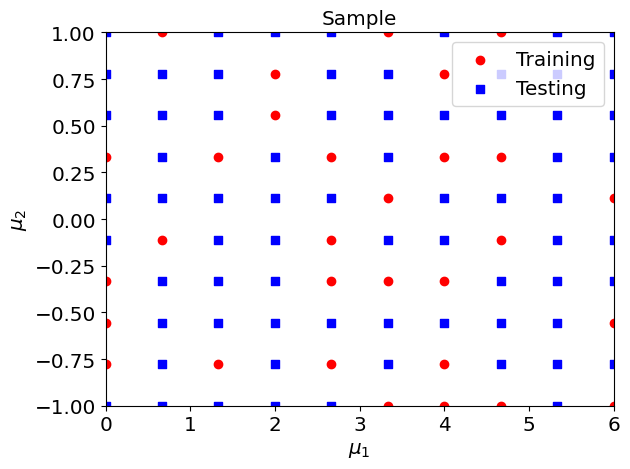

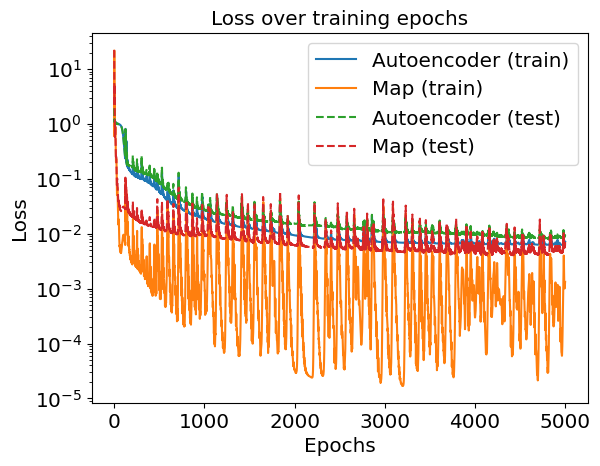

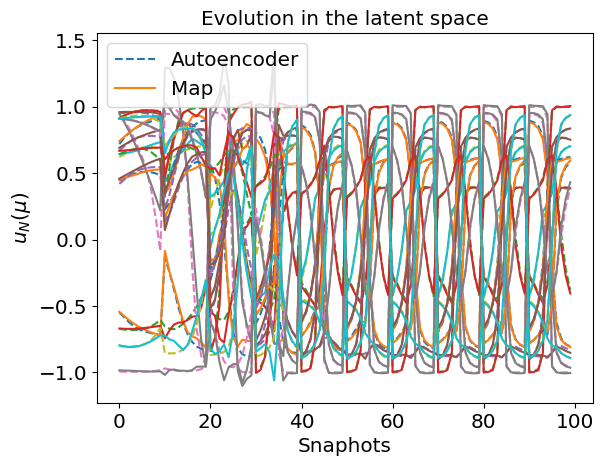

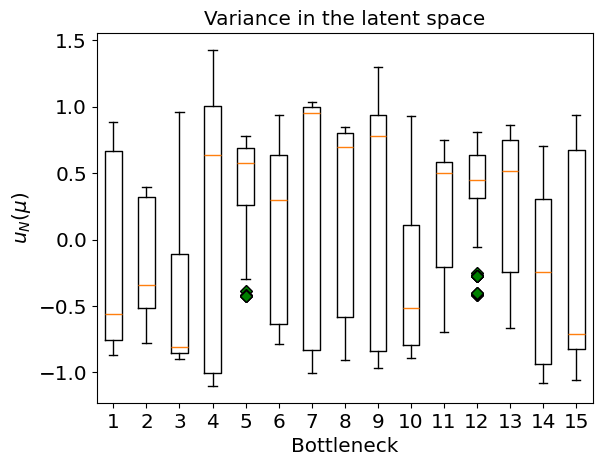

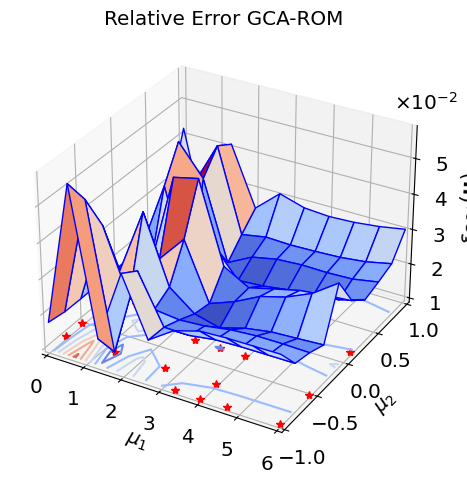

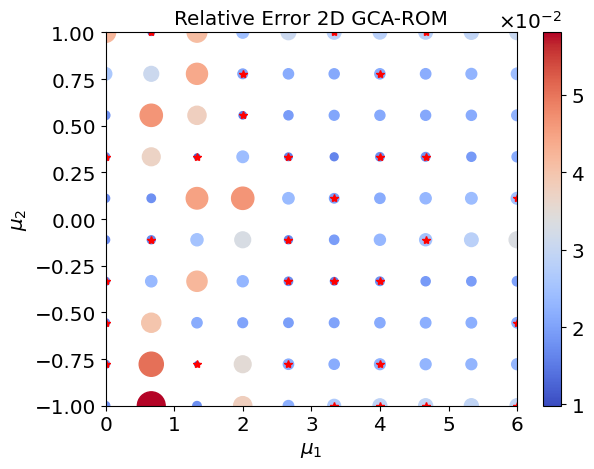

In [13]:
plotting.plot_sample(HyperParams, mu_space, params, train_trajectories, test_trajectories)
plotting.plot_loss(HyperParams)
plotting.plot_latent(HyperParams, latents_map, latents_gca)

plotting.plot_error(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)
plotting.plot_error_2d(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)

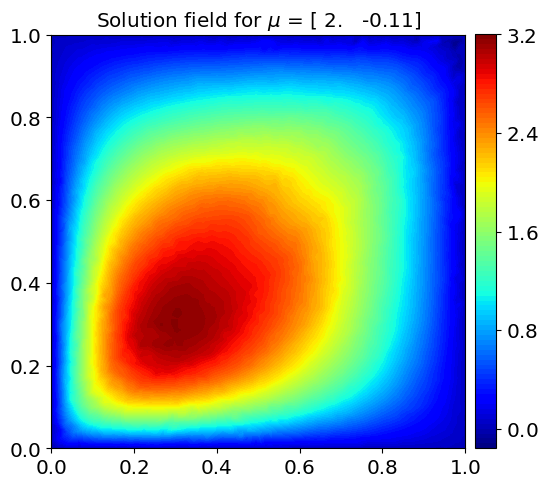

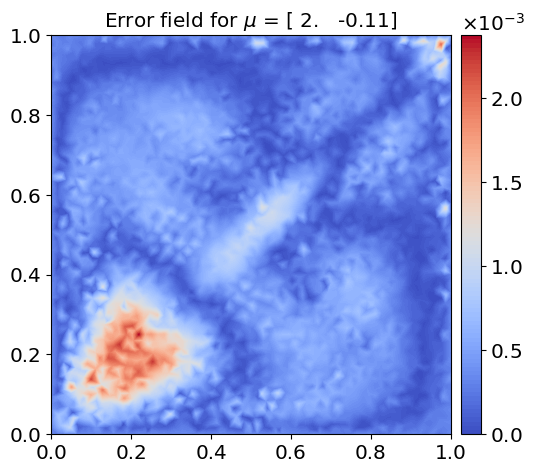

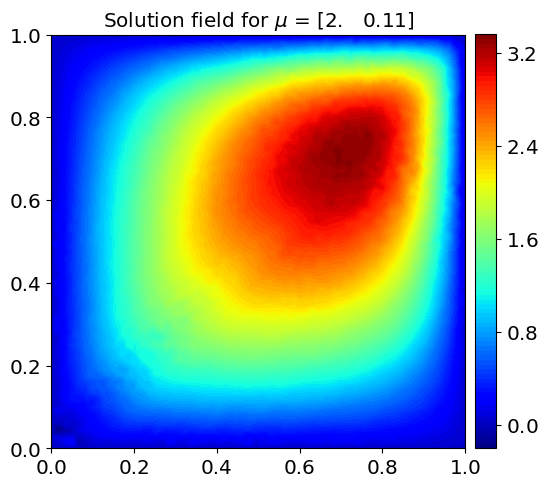

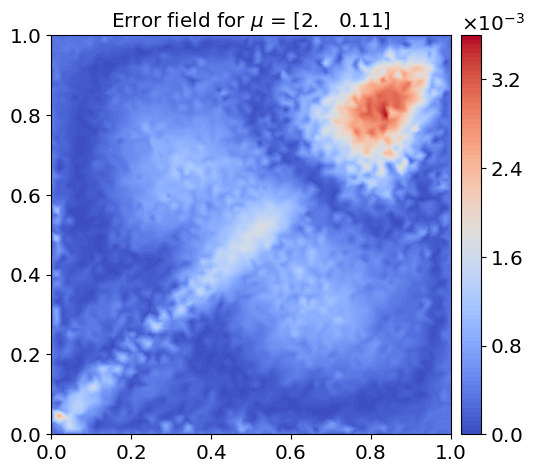

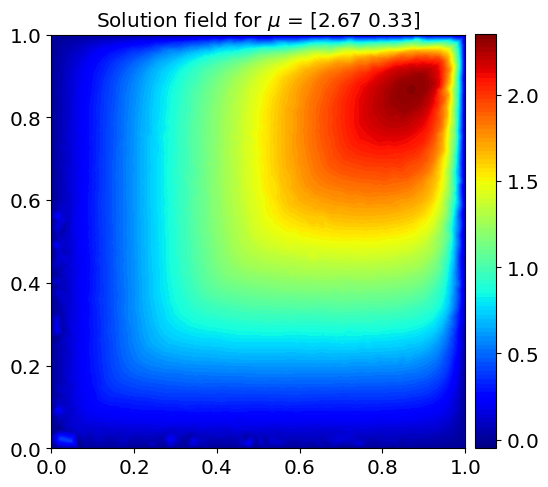

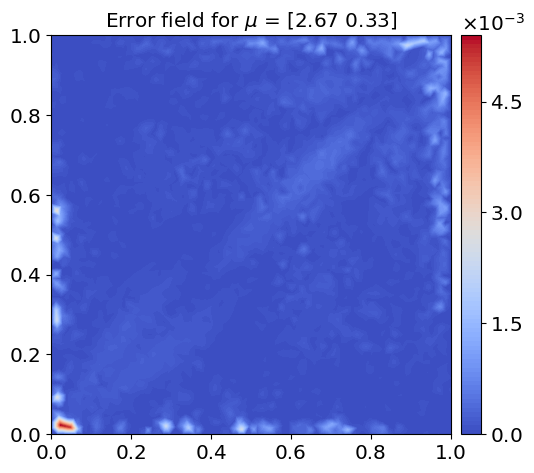

In [14]:
N = 3
snapshots = np.arange(params.shape[0]).tolist()
np.random.shuffle(snapshots)
for SNAP in snapshots[0:N]:
    plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, xyz, params)
    plotting.plot_error_fields(SNAP, results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)

# Print the errors on the testing set

100%|██████████| 70/70 [00:00<00:00, 131.61it/s]



Maximum absolute error for field GCA-ROM =  7.484369401518048
Mean absolute error for field GCA-ROM =  1.4894942631031258
Minimum absolute error for field GCA-ROM =  0.048869180993815355

Maximum relative error for field GCA-ROM =  0.06716574184486858
Mean relative error for field GCA-ROM =  0.032009115717507766
Minimum relative error for field GCA-ROM =  0.019271704041889343


<Figure size 640x480 with 0 Axes>

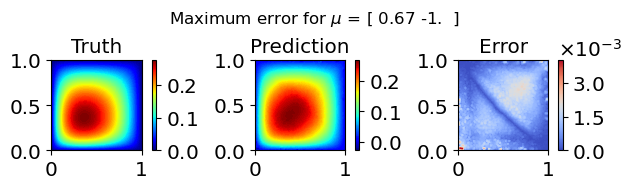

In [15]:
results_test, _, _ = testing.evaluate(VAR_test, model, val_loader, params, HyperParams, test_trajectories)

error_abs, norm = error.compute_error(results_test, VAR_test, scaler_test, HyperParams)
error.print_error(error_abs, norm, vars)
error.save_error(error_abs, norm, HyperParams, vars)

plotting.plot_comparison_fields(results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)